#   5.3 초모수와 모델 검증

In [21]:
#모델 검증
#1. 모델과 모델의 초모수를 선택
#2. 훈련 데이터 일부에 이를 적용하고 예측값을 알려진 값과 비교해서 모델이 얼마나 효율적인지 추정

#검정 표본 사용(모델의 성능을 제대로 알기위해)
#즉, 모델의 훈련 데이터에서 데이터의 일부를 빼내 모델 성능을 확인하는 검정표본(train_test_split사용)

from sklearn.datasets import load_iris
iris = load_iris()
X=iris.data
y=iris.target

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

from sklearn.model_selection import train_test_split
#데이터를 각각 50%로 나눔
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# 모델을 이 가운데 하나의 데이터 집합에 적용시킴
model.fit(X1, y1)

# 모델을 두 번째 데이터 집합으로 검증
y2_model = model.predict(X2)

from sklearn.metrics import accuracy_score
accuracy_score(y2, y2_model)

0.9066666666666666

In [7]:
!pip install Scikit-Learn

In [23]:
#교차 검증을 통한 모델 검증
#검정 표본을 사용하면 모델을 훈련시킬 데이터의 일부 손실
#해결하기 위해 교차 검증
#즉, 데이터의 각 하위 집합이 훈련 자료와 검증자료로 사용되도록

#굳이 넣을 필요 X
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5) #데이터를 5그룹으로 나눠 검증 시행을 할 때마다 차례대로 하나씩 모델 평가

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In [29]:
#최고의 모델 선택하기
#검증 곡선
#1. 훈련점수는 검증 점수보다 높다
#2. 모델 복잡도가 너무 낮으면 훈련 데이터가 과소적합
#3. 모델 복잡도가 너무 높으면 훈련 데이터가 과대적합
#4. 중간값에서 검증 곡선은 최댓값 -> 편향과 분산 사이의 적절한 트레이드 오프가 이루어졌다

In [31]:
#Scikit-Learn의 검증 곡선
#여기서 다항 회귀모델 사용
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [33]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

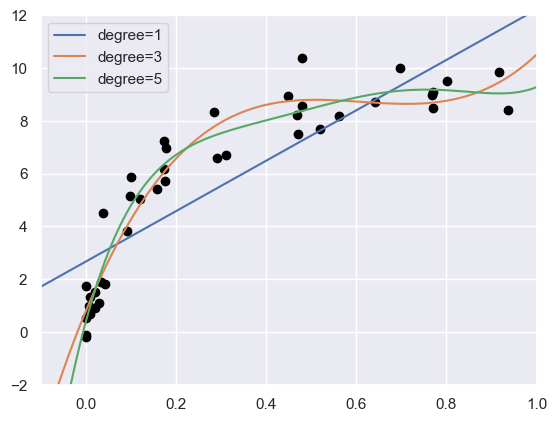

In [37]:
#다항식 적합을 시각화
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

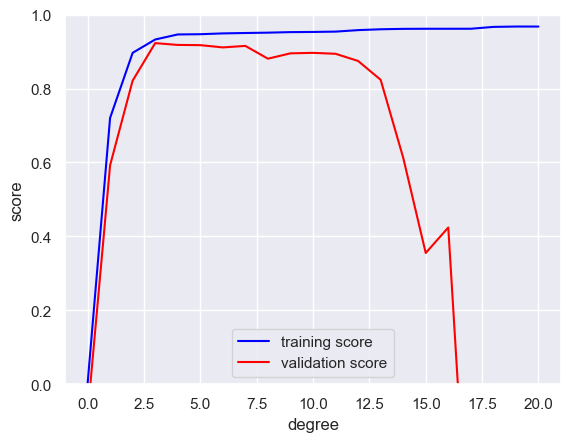

In [45]:
#validation_curve를 사용하여 모델과 데이터, 모수 이름, 탐색 범위가 주어지면 함수가 자동으로 그 범위 내에서 훈련 점수와 검증 점수를 계산함
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');
#이를 통해 최적의 트레이드오프가 3차 다항식임을 알 수 있음

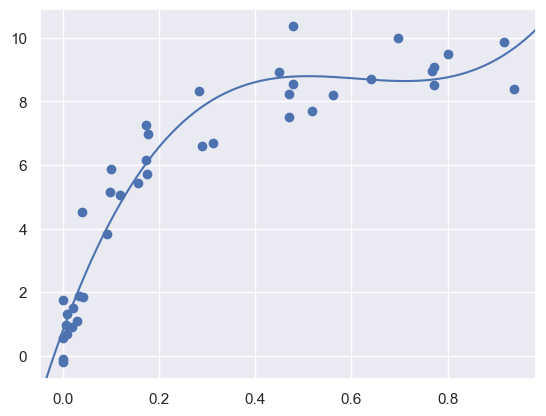

In [47]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

In [49]:
#학습곡선
#최적의 모델은 훈련 데이터의 규모에 의존하기도함
#학습곡선이란 훈련 집합의 크기에 따른 훈련점수/검증 점수의 플롯

#복잡도의 모델은 작은 데이터세트를 과대적합함
#복잡도의 모델은 큰 데이터세트를 과소적합함
#모델은 결코 훈련 집합보다 검증 집합에 더 좋은 점수를 주지 않음(즉, 교차하지 않음)

#특징으로 훈련 표본의 개수가 커질수록 특정 점수로 수렴함
#즉, 훈련 데이터를 더 늘리는 것은 도움이 되질 않음

In [51]:
#실제 검증 : 그리드 검색
#실제 모델에서 복잡도를 제어할 수 있는 수단이 하나 이상 있어 검증 곡선과 학습 곡선 플롯이 직선에서 다차원 표면으로 변경됨
#시각화하기 어려우므로 검증 점수를 최대화하는 특정 모델을 찾는 것이 나음
#Scikit-Learn이 grid_search모듈로 자동화 해줌


from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [53]:
grid.fit(X, y);

ValueError: Invalid parameter 'normalize' for estimator LinearRegression(). Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'positive'].

In [57]:
grid.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# 5.4 특징 공학

In [61]:
#특징 공학이란 문제에 대해 가지고 잇는 정보를 모두 취해 특징 행렬을 구축하는데 사용할 수 있는 숫자로 변환하는 것

In [63]:
# 범주 특징
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

In [73]:
#{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3}; 이런식으로 나타내고 싶음
#해당 범주의 유무를 각각 1이나 0으로 나타내는 추가 열을 생성하는 원-핫 인코딩 사용하기
# Scikit-Learn의 DictVectorizer이 지원함


from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)
#지역 열이 세 개의 레이블을 나타내는 세 개의 분리된 열로 확장됐고 각 행에는 그 지역과 관련된 열에 1이라는 값이 들어있음

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

In [69]:
vec.get_feature_names_out()

array(['neighborhood=Fremont', 'neighborhood=Queen Anne',
       'neighborhood=Wallingford', 'price', 'rooms'], dtype=object)

In [71]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int32'>'
	with 12 stored elements in Compressed Sparse Row format>

In [75]:
#텍스트 특징
#텍스트를 대표 수치값의 집합으로 변환
#데이터를 인코딩하는 가장 간단한 방법 중 하나는 단어 세게를 이용하는 것

In [79]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']
# 이 데이터를 벡터화 하려면 단어를 나타내는 열을 만들어야함
#scikit-learn의 countvectorizer가 지원함

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [87]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
#dataframe을 사용하면 검사하기 더 쉬워짐

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


In [89]:
#이미지 특징
#간단히 픽셀값 자체를 사용하는 것

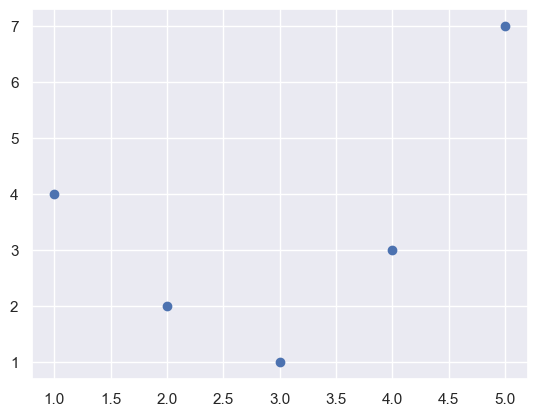

In [91]:
#유도 특징
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y)

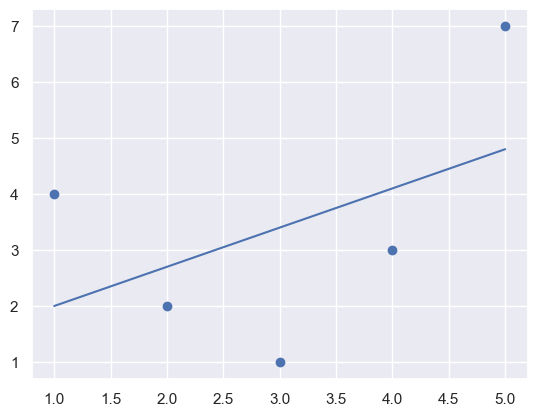

In [95]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);
#LinearRegression으로 최적의 결과 얻을 수 잇음

In [97]:
#x,y사이의 관계를 설명하기 위해 더 복잡한 모델 필요
# 이를 데이터를 변환해서 모델에 유연성을 더 부여할 수 있는 특징 열을 추가해서 할 수 있음
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


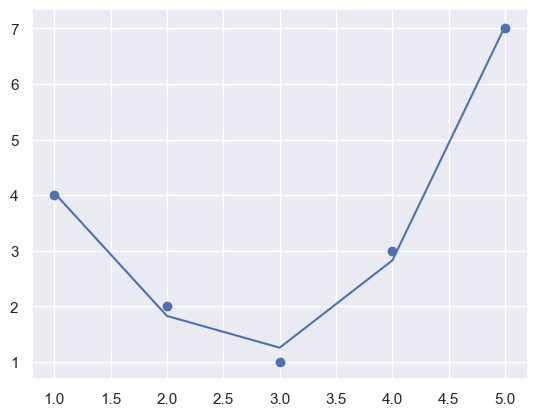

In [99]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

In [101]:
#누락 데이터의 대체
#누락된 데이터(Nan)을 적젏나 채움 값으로 대체

from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

In [109]:
#평균이나 중앙값, 최빈값을 사용하는 기본 대체 방식의 경우, Imputer클래스를 제공함
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

In [111]:
#정리하면 
#누락된 값을 평균으로 대체
#특징을 이차 형태로 전환
#선형 회귀를 적합시킴

# 5.5 심화 학습 : 나이브 베이즈 분류

In [114]:
#나이브 베이즈 모델은 대체로 매우 높은 차원의 데이터세트에 적합한 상당히 빠르고 간단한 분류 알고리즘을 가짐

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

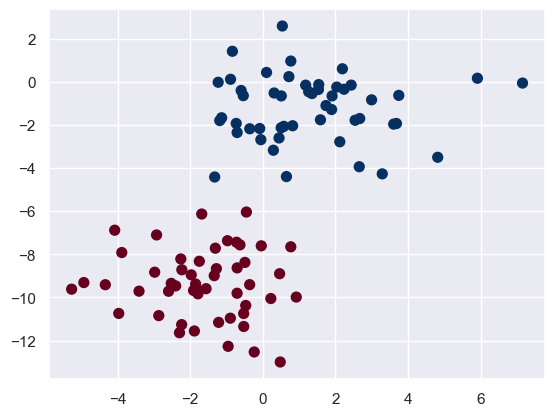

In [7]:
#가우스 나이브 베이즈
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

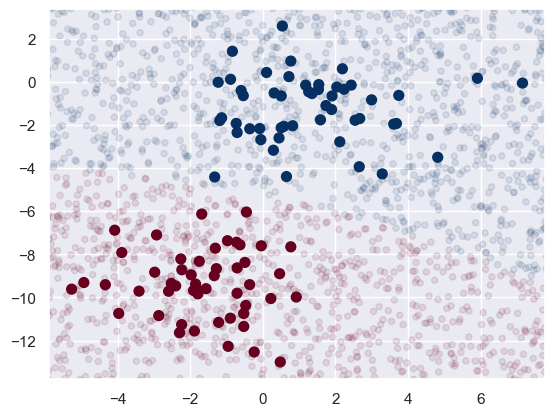

In [9]:
#간단한 모델을 만드는 가장 빠른 방법은 데이터가 차원 사이에 공분산이 없는 가우스 분포를 따른다고 가정하는것
#타원은 타원의 중심으로 갈수록 확률이 더 커지는 각 레이블에 대한 가우스 생성 모델을 나타냄
#각 클래스에 대해 이 생성 모델이 준비되면 모든 데이터 점에 대한 우도 P(features|L)을 계산할 수 있는
#간단한 방법이 생긴 셈이니 신속하게 사후 확률을 계산해서 주어진 점에 대해 어느 레이블이 가장 확률이 높은지
#결정할 수 있음
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

In [11]:
yprob = model.predict_proba(Xnew)
#베이즈 형식주의의 좋은 점은 자연스럽게 확률적인 분류가 가능하다는 것이며, predict_proba메서드를 사용해 그 확률을 계산할 수 있음
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

In [13]:
#다항분포 나이브 베이즈
#특징이 간단한 다항분포로부터 생성된다고 가정함
#계수나 계수율을 나타내는 특징에 가장 적절함

from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [15]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [17]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [21]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

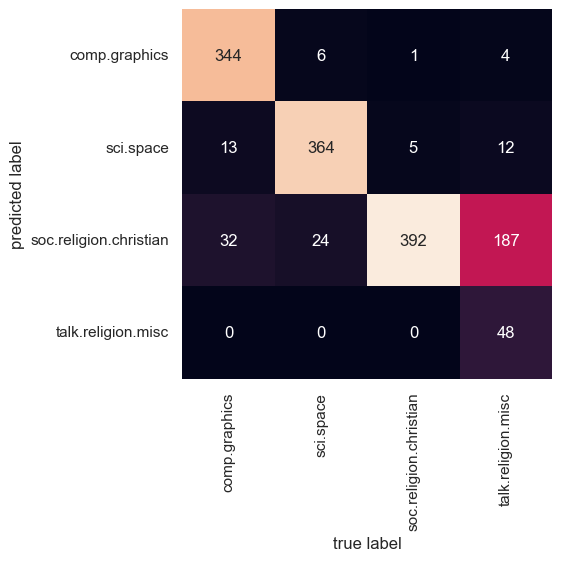

In [23]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [25]:

def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [27]:

predict_category('sending a payload to the ISS')

'sci.space'

In [29]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [31]:
predict_category('determining the screen resolution')

'comp.graphics'

# 5.10 심화학습 : 다양체 학습

In [45]:
#다양체 학습 : "HELLO"
#2차원 데이터를 생성
def make_hello(N=1000, rseed=42):
    # "HELLO" 텍스트로 플로팅해서 PNG 파일로 저장
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # 이 PNG 파일을 열어 임의의 점을 추출
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

C:\Users\user\AppData\Local\Temp\ipykernel_18024\1703149913.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))


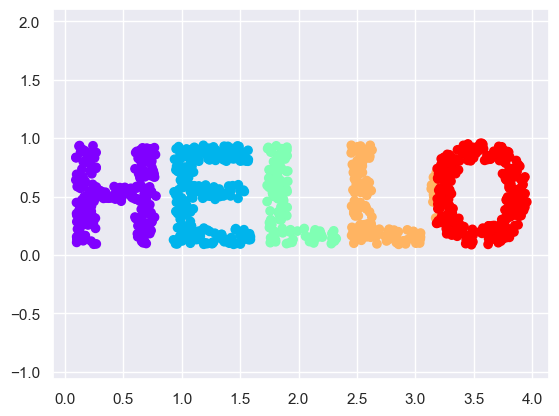

In [39]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

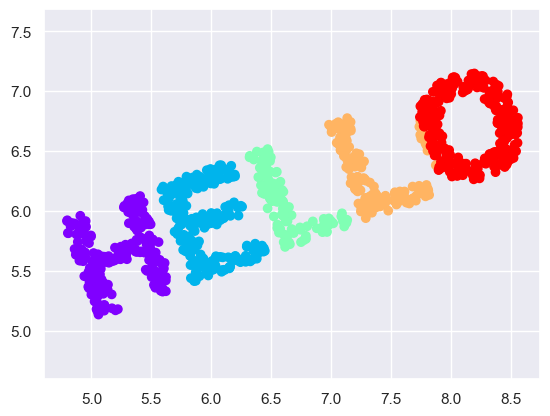

In [47]:
#다차원 척도법(MDS, Multidimensional Scaling)
def rotate(X, angle): #회전 행렬을 사용해 데이터를 회전하면 x,y값이 바뀌지만 그 데이터는 기본적으로 여전히 같음
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');
# x,y값이 데이터의 관계에 있어 근본적인 것은 아니라는 사실을 알 수 있음
#근본적인 것은 데이터세트의 점과 점 사이의 거리
#이를 표현하는 보편적인 방식은 거리 행렬을 사용하는것
#scikit-learn의 효율적인 pairwise_distances함수를 사용함

In [49]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

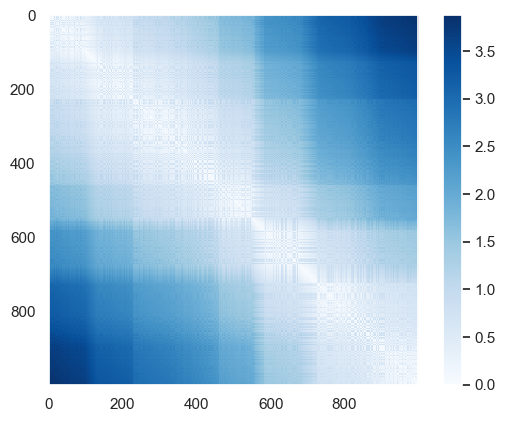

In [51]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

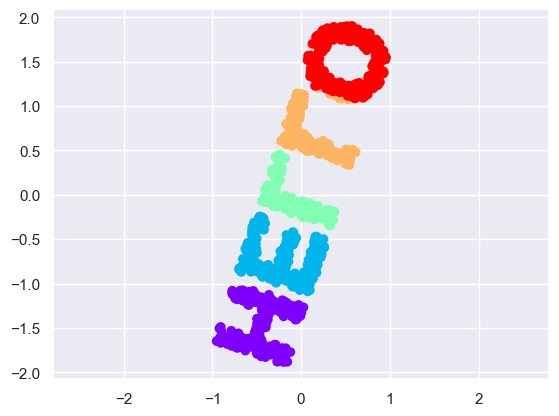

In [53]:
#x,y 좌표에서 거리 행렬을 계산하는 것은 간단하지만, 거리로부터 x,y좌표를 다시 변환하는 것은 어려움
#이것이 다차원 척도법 알고리즘이 하려는 일
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

In [55]:
#다양체 학습으로서의 MDS
#MDS추정기에 3차원 데이터를 입력하고 거리 행렬을 계산한 다음, 이 거리 행렬에 대한 최적의 2차원 임베딩을 결정하도록 요청
#결과는 원본 데이터의 표현을 복구

def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

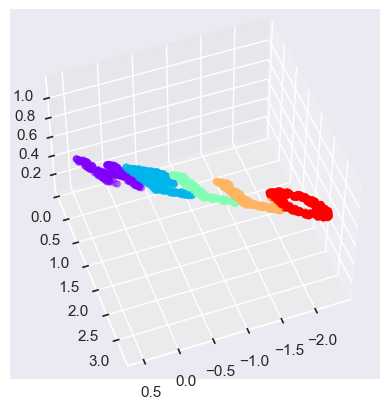

In [57]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

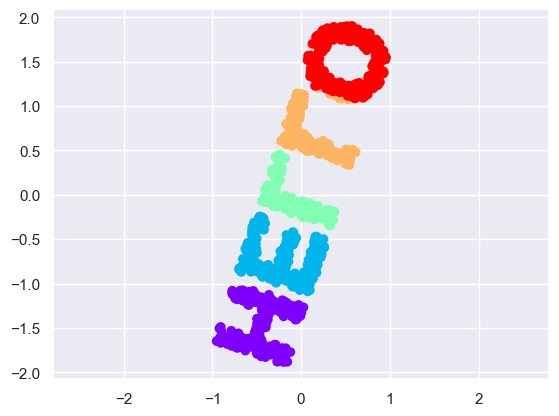

In [59]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

In [61]:
#비선형 임베딩 : MDS가 실패한 경우
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

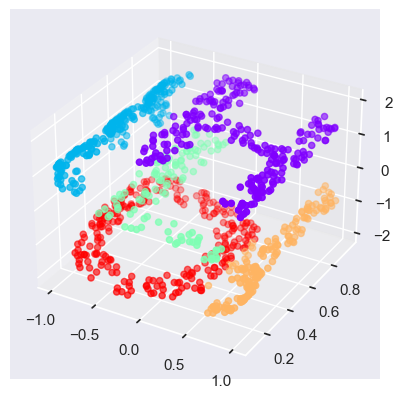

In [63]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],**colorize);

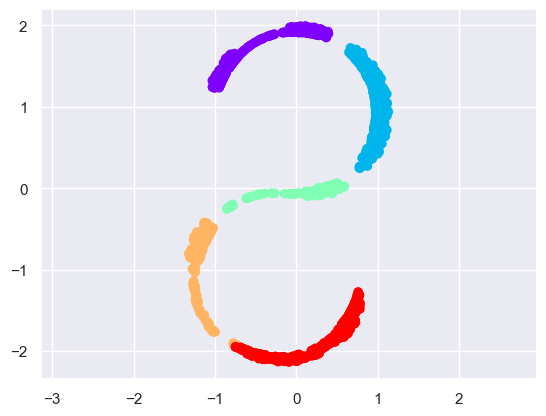

In [65]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

# 5.12 심화 학습 : 가우스 혼합 모델

In [72]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


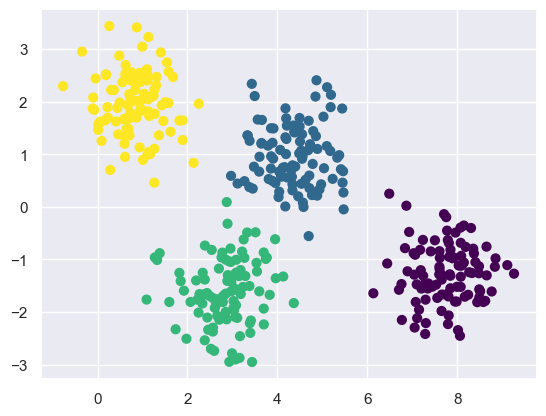

In [74]:

# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [76]:

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


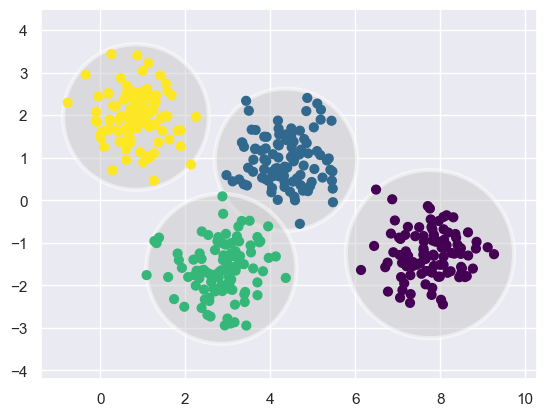

In [78]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


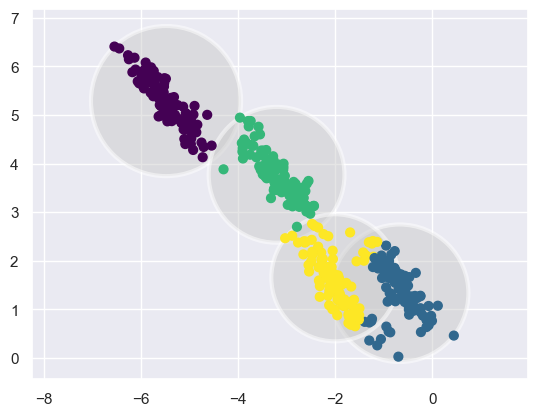

In [80]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


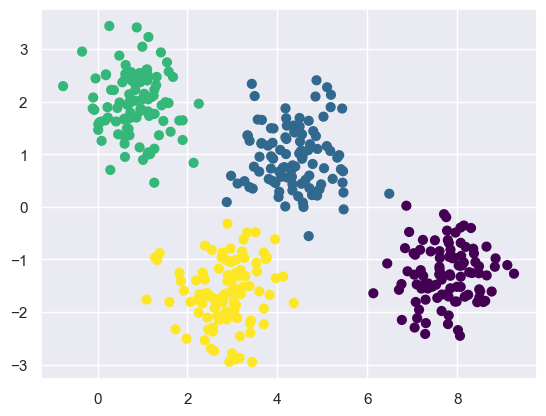

In [86]:
# Generalizing E–M: Gaussian Mixture Models
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [88]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.463 0.537 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]]


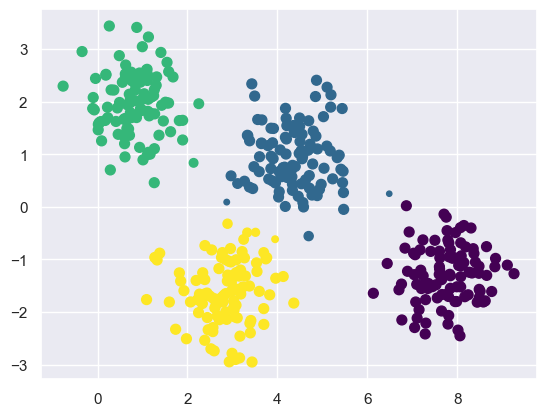

In [90]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [92]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


AttributeError: 'GaussianMixture' object has no attribute 'covars_'

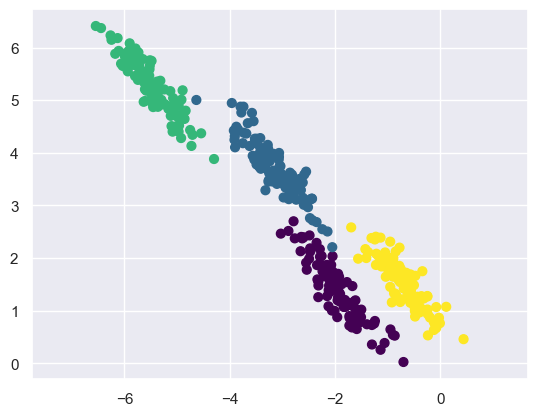

In [106]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

In [108]:
#공분산 유형 선택하기

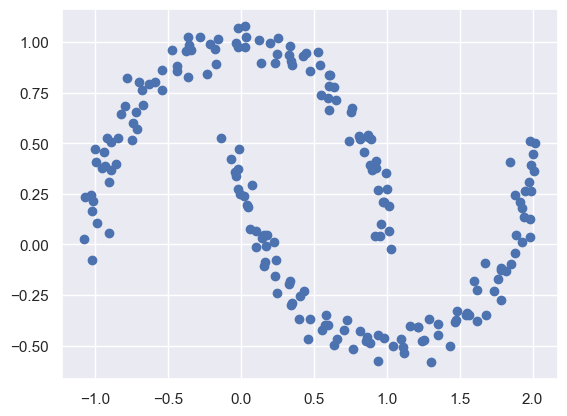

In [110]:
# 밀도 추정에 GMM 사용하기
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


AttributeError: 'GaussianMixture' object has no attribute 'covars_'

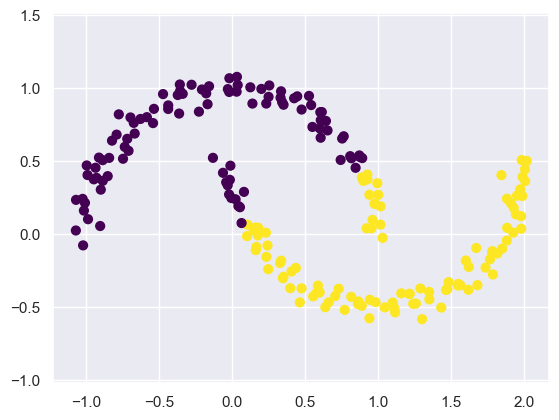

In [116]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


AttributeError: 'GaussianMixture' object has no attribute 'covars_'

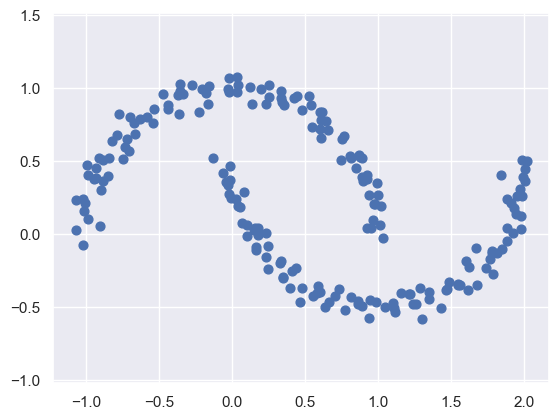

In [118]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

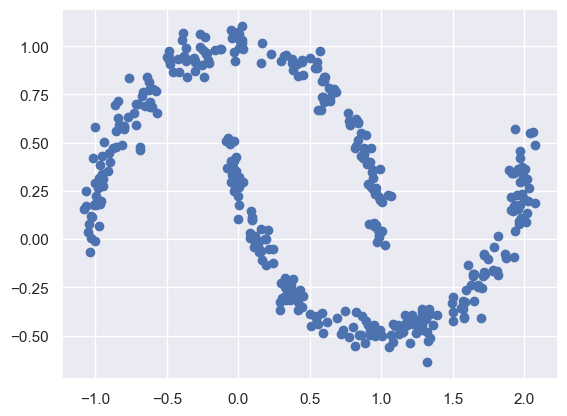

In [122]:
Xnew, ynew = gmm16.sample(400)
plt.scatter(Xnew[:,0], Xnew[:,1]);

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows wi

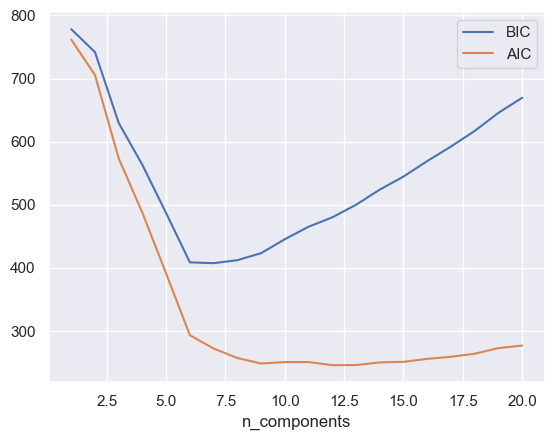

In [124]:
n_components = np.arange(1,21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

#   5.13 심화 학습: 커널 밀도 추정

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [129]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

AttributeError: Rectangle.set() got an unexpected keyword argument 'normed'

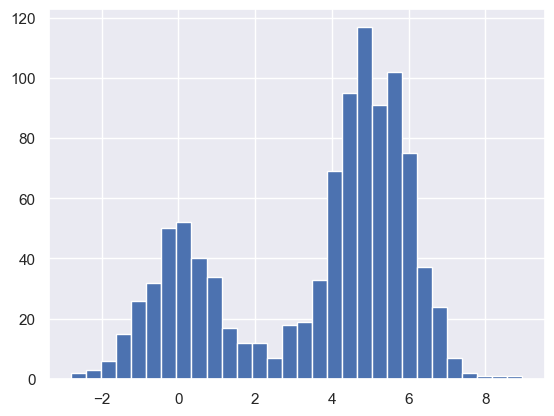

In [131]:
hist = plt.hist(x, bins=30, normed=True)